In [1]:
#Library
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import category_encoders as ce
#pip install category_encoders
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
#pip install xgboost
#pip install catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
#pip install optuna
import optuna

# Start!

In [2]:
train_perf_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/trainperf.csv')
test_perf_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/testperf.csv')

train_demo_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/traindemographics.csv')
test_demo_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/testdemographics.csv')
demo_df = pd.concat([test_demo_df,train_demo_df])
demo_df=demo_df.reset_index(drop=True)

train_prev_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/trainprevloans.csv')
test_prev_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/testprevloans.csv')
prev_df = pd.concat([train_prev_df,test_prev_df])
prev_df=prev_df.reset_index(drop=True)

In [3]:
print("Demo: ", train_demo_df.shape,test_demo_df.shape,demo_df.shape)
print("Prev: ", train_prev_df.shape,test_prev_df.shape,prev_df.shape)
print("Perf: ", train_perf_df.shape,test_perf_df.shape)

Demo:  (4346, 9) (1487, 9) (5833, 9)
Prev:  (18183, 12) (5907, 12) (24090, 12)
Perf:  (4368, 10) (1450, 9)


# Demo

In [4]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5833 entries, 0 to 5832
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  5833 non-null   object 
 1   birthdate                   5833 non-null   object 
 2   bank_account_type           5833 non-null   object 
 3   longitude_gps               5833 non-null   float64
 4   latitude_gps                5833 non-null   float64
 5   bank_name_clients           5833 non-null   object 
 6   bank_branch_clients         65 non-null     object 
 7   employment_status_clients   4968 non-null   object 
 8   level_of_education_clients  797 non-null    object 
dtypes: float64(2), object(7)
memory usage: 410.3+ KB


In [5]:
#MissingValue
demo_missing= pd.DataFrame(demo_df.isnull().mean().sort_values(ascending=False)*100,columns=['Percentage'])
demo_missing
#Remove bank_branch_clients & level_of_education_clients (over 85%)
#Impute employment_status_clients later in pipeline

,Percentage
bank_branch_clients,98.885651
level_of_education_clients,86.336362
employment_status_clients,14.829419
customerid,0.000000
birthdate,0.000000
bank_account_type,0.000000
longitude_gps,0.000000
latitude_gps,0.000000
bank_name_clients,0.000000


In [6]:
demo_df.drop(demo_missing.index[0:2].tolist(),axis=1,inplace=True)

In [7]:
#Calculate Age using birthdate
from datetime import date
from datetime import datetime
s = []
days_in_year = 365.2425 
for i in demo_df['birthdate']:
    age = ((date.today() - datetime.strptime(i[:10],'%Y-%m-%d').date())/365.2425).days
    s.append(age)
demo_df['Age']=s
demo_df['Age']=demo_df['Age'].astype(int)
demo_df.drop('birthdate',axis=1,inplace=True)

In [8]:
demo_df.head(20)

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Age
0,8a858f305c8dd672015c93b1db645db4,Savings,5.296628,7.593965,Heritage Bank,Permanent,46
1,8a858f085a477386015a47fb049e49ca,Savings,3.294513,6.596602,UBA,Permanent,44
2,8a858e6f5cd5e874015cd6f5634c39ad,Savings,8.501912,7.729364,First Bank,Permanent,38
3,8a858e9d5bfd7037015bfdab79f61305,Savings,3.318904,6.681595,UBA,Permanent,39
4,8a858fde56eb02280156eb6dafc128ac,Savings,6.354624,4.949031,First Bank,Self-Employed,40
5,8a858e695775665c015779a1a5cc1192,Other,3.307558,7.112214,Access Bank,Self-Employed,34
6,8a858e225c404292015c4e2b42c67bbe,Savings,8.349746,4.964838,First Bank,Permanent,36
7,8a858fcf5b39c3ba015b3d9f215c3922,Savings,3.892932,7.408140,GT Bank,NaN,44
8,8a858edd5c8348c4015c8452bc364cd7,Savings,3.432870,6.837874,Stanbic IBTC,NaN,40
9,8a858ef25c8393f8015c86783932595b,Savings,7.527908,6.427476,Diamond Bank,Permanent,31


In [9]:
#Check if any duplicate customerid
print(len(demo_df['customerid'].unique()),demo_df.shape[0])
#15 duplicates

5818 5833


In [10]:
demo_df[demo_df.duplicated('customerid',keep=False)].sort_values('customerid')
#extactly same, just keep one record

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Age
497,8a8588b75438f49901544510041e0951,Other,3.342808,6.542411,Zenith Bank,Permanent,42
502,8a8588b75438f49901544510041e0951,Other,3.342808,6.542411,Zenith Bank,Permanent,42
3415,8a858e625c8d993a015c938f829f77ee,Savings,5.768333,5.561992,First Bank,Permanent,33
2901,8a858e625c8d993a015c938f829f77ee,Savings,5.768333,5.561992,First Bank,Permanent,33
2577,8a858e6c5c88d145015c8b9627cd5a48,Savings,3.367008,6.497313,Sterling Bank,Permanent,43
1932,8a858e6c5c88d145015c8b9627cd5a48,Savings,3.367008,6.497313,Sterling Bank,Permanent,43
248,8a858e885b68546c015b7238f22027ba,Savings,3.353123,6.587837,First Bank,Permanent,47
810,8a858e885b68546c015b7238f22027ba,Savings,3.353123,6.587837,First Bank,Permanent,47
3483,8a858ec65cc6352b015cc64525ea0763,Savings,3.845728,7.411737,GT Bank,Permanent,37
3007,8a858ec65cc6352b015cc64525ea0763,Savings,3.845728,7.411737,GT Bank,Permanent,37


In [11]:
#Drop duplicate
demo_df.drop_duplicates('customerid',inplace=True)

In [12]:
#pip install geopy

#s = []
#for i in range(0,train_perf_df.shape[0]):
#    duration = round((datetime.strptime(train_perf_df['approveddate'][i],"%Y-%m-%d %H:%M:%S.%f")-
#    datetime.strptime(train_perf_df['creationdate'][i],"%Y-%m-%d %H:%M:%S.%f")).seconds/3600,2)
#    s.append(duration)
#train_perf_df['ApproveDuration']=s


In [13]:
demo_df

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Age
0,8a858f305c8dd672015c93b1db645db4,Savings,5.296628,7.593965,Heritage Bank,Permanent,46
1,8a858f085a477386015a47fb049e49ca,Savings,3.294513,6.596602,UBA,Permanent,44
2,8a858e6f5cd5e874015cd6f5634c39ad,Savings,8.501912,7.729364,First Bank,Permanent,38
3,8a858e9d5bfd7037015bfdab79f61305,Savings,3.318904,6.681595,UBA,Permanent,39
4,8a858fde56eb02280156eb6dafc128ac,Savings,6.354624,4.949031,First Bank,Self-Employed,40
...,...,...,...,...,...,...,...
5828,8a858f155554552501555588ca2b3b40,Other,3.236753,7.030168,Stanbic IBTC,Permanent,36
5829,8a858fc65cf978f4015cf97cee3a02ce,Savings,7.013750,4.875662,GT Bank,NaN,40
5830,8a858f4f5b66de3a015b66fc83c61902,Savings,6.295530,7.092508,GT Bank,Permanent,33
5831,8aaae7a74400b28201441c8b62514150,Savings,3.354206,6.539070,GT Bank,Permanent,37


In [14]:
#Check Again!
print(len(demo_df['customerid'].unique()),demo_df.shape[0])

5818 5818


# Prev

In [15]:
prev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24090 entries, 0 to 24089
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       24090 non-null  object 
 1   systemloanid     24090 non-null  int64  
 2   loannumber       24090 non-null  int64  
 3   approveddate     24090 non-null  object 
 4   creationdate     24090 non-null  object 
 5   loanamount       24090 non-null  float64
 6   totaldue         24090 non-null  float64
 7   termdays         24090 non-null  int64  
 8   closeddate       24090 non-null  object 
 9   referredby       1351 non-null   object 
 10  firstduedate     24090 non-null  object 
 11  firstrepaiddate  24090 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 2.2+ MB


In [16]:
#MissingValue
prev_missing= pd.DataFrame(prev_df.isnull().mean().sort_values(ascending=False)*100,columns=['Percentage'])
prev_missing
#referredby: Yes - Not Null; No - Null

,Percentage
referredby,94.391864
customerid,0.000000
systemloanid,0.000000
loannumber,0.000000
approveddate,0.000000
creationdate,0.000000
loanamount,0.000000
totaldue,0.000000
termdays,0.000000
closeddate,0.000000


In [17]:
##Drop Refer_By
prev_df.drop('referredby',axis=1,inplace=True)

In [18]:
prev_df.head(50)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000
5,8a858970548359cc0154883481981866,301832407,5,2017-03-06 13:25:17.000000,2017-03-06 12:25:10.000000,20000.0,23800.0,30,2017-04-04 15:46:56.000000,2017-04-05 00:00:00.000000,2017-04-04 15:31:47.000000
6,8a858970548359cc0154883481981866,301926513,8,2017-06-04 01:00:23.000000,2017-06-04 00:00:16.000000,30000.0,39000.0,60,2017-07-03 23:35:38.000000,2017-07-04 00:00:00.000000,2017-07-03 23:25:29.000000
7,8a8589f35451855401546b0738c42524,301912443,6,2017-05-18 09:42:18.000000,2017-05-18 08:41:12.000000,20000.0,24500.0,30,2017-06-19 10:10:35.000000,2017-06-19 00:00:00.000000,2017-06-19 10:00:21.000000
8,8a858e095c59b91b015c5e5cea3719bc,301936857,2,2017-06-13 08:26:31.000000,2017-06-13 07:26:24.000000,10000.0,13000.0,30,2017-07-10 13:32:03.000000,2017-07-13 00:00:00.000000,2017-07-10 13:21:53.000000
9,8a858e1158dc4d830158f7bde4f47ea7,301811291,3,2017-02-06 18:55:30.000000,2017-02-06 17:55:20.000000,10000.0,11500.0,15,2017-02-21 05:34:20.000000,2017-02-21 00:00:00.000000,2017-02-21 05:19:09.000000


In [19]:
#ApprovedDuration
s = []
for i in range(0,prev_df.shape[0]):
    duration = round((datetime.strptime(prev_df['approveddate'][i],"%Y-%m-%d %H:%M:%S.%f")-
    datetime.strptime(prev_df['creationdate'][i],"%Y-%m-%d %H:%M:%S.%f")).seconds/3600,2)
    s.append(duration)
prev_df['ApproveDuration']=s

#Pay1st_Duration
s = []
for i in range(0,prev_df.shape[0]):
    duration = round((datetime.strptime(prev_df['firstrepaiddate'][i][:10],'%Y-%m-%d')-
    datetime.strptime(prev_df['firstduedate'][i][:10],'%Y-%m-%d')).days)
    s.append(duration)
prev_df['Pay1st_Duration']=s

#Pay_Duration
s = []
for i in range(0,prev_df.shape[0]):
    duration = (datetime.strptime(prev_df['closeddate'][i][:10],'%Y-%m-%d')-
    datetime.strptime(prev_df['approveddate'][i][:10],'%Y-%m-%d')).days-prev_df['termdays'][i]
    s.append(duration)
prev_df['Pay_Duration']=s

In [20]:
#Pay_OnTime_1st: if firstduedate >= firstpaiddate then Yes, else No
s = []
for i in range(0,prev_df.shape[0]):
    OnTime = datetime.strptime(prev_df['firstduedate'][i][:10],'%Y-%m-%d')>=datetime.strptime(prev_df['firstrepaiddate'][i][:10],'%Y-%m-%d')
    s.append(OnTime)
prev_df['Pay_OnTime_1stPayment']=s
prev_df['Pay_OnTime_1stPayment']=prev_df['Pay_OnTime_1stPayment'].apply(lambda x: 1 if x == True else 0)

#Pay_OnTime: if closeddate - approveddate <= termdays then Yes, else No
s = []
for i in range(0,prev_df.shape[0]):
    Delta = datetime.strptime(prev_df['closeddate'][i][:10],'%Y-%m-%d')-datetime.strptime(prev_df['approveddate'][i][:10],'%Y-%m-%d')
    Diff = Delta.days - prev_df['termdays'][i]
    s.append(Diff)
prev_df['Pay_OnTime']=s
prev_df['Pay_OnTime']=prev_df['Pay_OnTime'].apply(lambda x: 1 if x <= 0 else 0)#

prev_df[['Pay_OnTime_1stPayment','Pay_OnTime']].describe()

#Drop firstduedate, firstpaiddate, closeddate & approveddate
#Also Drop systemloanid & loanamount (will use total due instead)
#prev_df.drop(['firstduedate','firstrepaiddate','closeddate', 'approveddate','creationdate',
#              'systemloanid','loanamount'],axis=1,inplace=True)

,Pay_OnTime_1stPayment,Pay_OnTime
count,24090.000000,24090.00000
mean,0.822623,0.75301
std,0.381995,0.43127
min,0.000000,0.00000
25%,1.000000,1.00000
50%,1.000000,1.00000
75%,1.000000,1.00000
max,1.000000,1.00000


In [21]:
#interest
prev_df['interest']=prev_df['totaldue']-prev_df['loanamount']

#termdays for Pay_OnTime_1stPayment=1
prev_df['termday_Pay_OnTime_1stPayment']=prev_df['termdays']*prev_df['Pay_OnTime_1stPayment']

#termdays for Pay_OnTime=1
prev_df['termday_Pay_OnTime']=prev_df['termdays']*prev_df['Pay_OnTime']

In [22]:
#Caluculate avg loan duation
lastloan=prev_df.sort_values("loannumber").drop_duplicates("customerid",keep="last")
lastloan=lastloan[['customerid','loannumber','approveddate','closeddate']]

firstloan=prev_df.sort_values("loannumber").drop_duplicates("customerid",keep="first")
firstloan=firstloan[['customerid','loannumber','approveddate','closeddate']]

loan_duration=pd.merge(firstloan, lastloan, how='left', on=['customerid', 'customerid'])
loan_duration.columns=['customerid','loannumber_1st','approveddate_1st','closeddate_1st','loannumber_last','approveddate_last',
                       'closeddate_last']

s = []
for i in range(0,loan_duration.shape[0]):
    duration = round((datetime.strptime(loan_duration['closeddate_last'][i][:10],'%Y-%m-%d')-
    datetime.strptime(loan_duration['approveddate_1st'][i][:10],'%Y-%m-%d')).days)
    s.append(duration)
loan_duration['loan_duration']=s

loan_duration['prev_avg_loan_duration']=loan_duration['loan_duration']/(loan_duration['loannumber_last']-loan_duration['loannumber_1st']+1)
loan_duration=loan_duration[['customerid','prev_avg_loan_duration']]
loan_duration

,customerid,prev_avg_loan_duration
0,8a858e6c5c88d145015c894de5001cce,29.000000
1,8a858feb55f82bbf0155f85225000130,36.600000
2,8a858eae5bb5beb8015bbb0a34bf0472,22.333333
3,8a858fa05908043801590ced4e786bd6,104.500000
4,8a858fcf5a192144015a1d262059287d,24.000000
...,...,...
5796,8a8589b953bc23f70153ccc3fd3519c7,25.000000
5797,8a399f284741b63b0147496a04db1eb4,49.000000
5798,8a688b474ed5e088014ed8b6c50c5f51,20.000000
5799,8a85895354be33300154c4e81edf0dd7,28.000000


In [23]:
prev_df=prev_df.groupby('customerid',as_index=False).agg({'totaldue': ['mean'],
                                                  'loanamount': ['mean','sum'],
                                                  'interest': ['mean'],
                                                  'systemloanid': ['count'],
                                                  'termdays': ['mean'], 
                                                  'ApproveDuration': ['mean'],
                                                  'Pay1st_Duration': ['mean'],
                                                  'Pay_Duration': ['mean'],
                                                  'Pay_OnTime_1stPayment': ['sum'],
                                                  'Pay_OnTime': ['sum'],
                                                  'termday_Pay_OnTime_1stPayment': ['sum'],
                                                  'termday_Pay_OnTime': ['sum']
                                                    })

prev_df.columns=['customerid','prev_totaldue_mean','prev_loanamount_mean','prev_loanamount_sum','prev_interest_mean',
                 'prev_loan_number','prev_termdays_mean','prev_approveDuration_mean','prev_Pay1st_Duration_mean',
                 'prev_Pay_Duration_mean','prev_1stpayment_ontime','prev_ontime','termdays_Pay_OnTime_1stPayment_mean',
                'termdays_Pay_OnTime_mean'
                ]

In [24]:
prev_df = pd.merge(prev_df, loan_duration, how='left', on=['customerid', 'customerid'])

In [25]:
prev_df

,customerid,prev_totaldue_mean,prev_loanamount_mean,prev_loanamount_sum,prev_interest_mean,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,8a1088a0484472eb01484669e3ce4e0b,11500.000000,10000.000000,10000.0,1500.000000,1,15.000000,1.020000,6.000000,7.000000,0,0,0,0,22.000000
1,8a1a1e7e4f707f8b014f797718316cad,22375.000000,17500.000000,70000.0,4875.000000,4,37.500000,1.005000,-0.250000,-5.750000,3,3,120,120,109.750000
2,8a1a32fc49b632520149c3b8fdf85139,15214.285714,12857.142857,90000.0,2357.142857,7,19.285714,1.004286,-0.428571,-0.285714,6,6,120,120,68.142857
3,8a1eb5ba49a682300149c3c068b806c7,20300.000000,16250.000000,130000.0,4050.000000,8,33.750000,1.002500,-3.125000,-5.125000,7,8,210,270,31.500000
4,8a1edbf14734127f0147356fdb1b1eb2,12250.000000,10000.000000,20000.0,2250.000000,2,22.500000,1.010000,-4.000000,-4.000000,2,2,45,45,20.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,8a858fff5c79144c015c7bdbfc086ce1,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.000000,-5.000000,-1.000000,1,1,30,30,29.000000
5797,8aaae7a74400b28201441c8b62514150,12500.000000,10000.000000,30000.0,2500.000000,3,25.000000,1.003333,-0.666667,-0.333333,3,2,75,45,28.000000
5798,8aab10f748cf78ff0148d11fac1447a6,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.020000,2.000000,4.000000,0,0,0,0,34.000000
5799,8aab160f499477da014999ba2f0f578b,11750.000000,10000.000000,30000.0,1750.000000,3,20.000000,1.006667,0.333333,1.333333,2,1,45,15,143.666667


In [26]:
#Termday_mean for pay on time
prev_df['termday_1st_divisor']=prev_df['prev_1stpayment_ontime'].apply(lambda x: 1 if x == 0 else x)
prev_df['termday_divisor']=prev_df['prev_ontime'].apply(lambda x: 1 if x == 0 else x)

prev_df['termdays_Pay_OnTime_1stPayment_mean']=prev_df['termdays_Pay_OnTime_1stPayment_mean']/prev_df['termday_1st_divisor']
prev_df['termdays_Pay_OnTime_mean']=prev_df['termdays_Pay_OnTime_mean']/prev_df['termday_divisor']
prev_df.drop(['termday_1st_divisor','termday_divisor'],axis=1,inplace=True)

prev_df['termdays_Pay_OnTime_1stPayment_mean']=prev_df['termdays_Pay_OnTime_1stPayment_mean'].apply(lambda x: np.nan if x == 0 else x)
prev_df['termdays_Pay_OnTime_mean']=prev_df['termdays_Pay_OnTime_mean'].apply(lambda x: np.nan if x == 0 else x)
prev_df['termdays_Pay_OnTime_1stPayment_mean'].fillna(prev_df['termdays_Pay_OnTime_1stPayment_mean'].mean(),inplace=True)
prev_df['termdays_Pay_OnTime_mean'].fillna(prev_df['termdays_Pay_OnTime_mean'].mean(),inplace=True)

In [27]:
prev_df

,customerid,prev_totaldue_mean,prev_loanamount_mean,prev_loanamount_sum,prev_interest_mean,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,8a1088a0484472eb01484669e3ce4e0b,11500.000000,10000.000000,10000.0,1500.000000,1,15.000000,1.020000,6.000000,7.000000,0,0,25.274832,25.529267,22.000000
1,8a1a1e7e4f707f8b014f797718316cad,22375.000000,17500.000000,70000.0,4875.000000,4,37.500000,1.005000,-0.250000,-5.750000,3,3,40.000000,40.000000,109.750000
2,8a1a32fc49b632520149c3b8fdf85139,15214.285714,12857.142857,90000.0,2357.142857,7,19.285714,1.004286,-0.428571,-0.285714,6,6,20.000000,20.000000,68.142857
3,8a1eb5ba49a682300149c3c068b806c7,20300.000000,16250.000000,130000.0,4050.000000,8,33.750000,1.002500,-3.125000,-5.125000,7,8,30.000000,33.750000,31.500000
4,8a1edbf14734127f0147356fdb1b1eb2,12250.000000,10000.000000,20000.0,2250.000000,2,22.500000,1.010000,-4.000000,-4.000000,2,2,22.500000,22.500000,20.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,8a858fff5c79144c015c7bdbfc086ce1,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.000000,-5.000000,-1.000000,1,1,30.000000,30.000000,29.000000
5797,8aaae7a74400b28201441c8b62514150,12500.000000,10000.000000,30000.0,2500.000000,3,25.000000,1.003333,-0.666667,-0.333333,3,2,25.000000,22.500000,28.000000
5798,8aab10f748cf78ff0148d11fac1447a6,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.020000,2.000000,4.000000,0,0,25.274832,25.529267,34.000000
5799,8aab160f499477da014999ba2f0f578b,11750.000000,10000.000000,30000.0,1750.000000,3,20.000000,1.006667,0.333333,1.333333,2,1,22.500000,15.000000,143.666667


In [28]:
#Check duplicate
print(len(prev_df['customerid'].unique()),prev_df.shape[0])

5801 5801


# Perf

In [29]:
train_perf_df.info()
print('_'*40)
test_perf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customerid    1450 non-null   object 
 1   systemloanid  1450 n

In [30]:
train_perf_df

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good
...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,2017-07-30 09:19:42.000000,2017-07-30 08:18:30.000000,10000.0,13000.0,30,NaN,Bad
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47.000000,2017-07-27 14:35:40.000000,10000.0,13000.0,30,NaN,Bad
4365,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57.000000,2017-07-25 15:24:47.000000,10000.0,11500.0,15,NaN,Bad
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27.000000,2017-07-14 12:50:21.000000,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,Bad


In [31]:
test_perf_df

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN
...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,301991141,3,47:02.0,46:53.0,10000,11500.0,15,NaN
1446,8a858fcb5b00cc54015b0253ced26a5f,301963018,3,00:45.0,04:05.0,10000,13000.0,30,NaN
1447,8a858fde56eb02280156f59b976d46c0,301994653,9,09:40.0,09:33.0,40000,48000.0,60,NaN
1448,8a858e10570f2d65015717fcfec44996,301961483,14,47:54.0,46:49.0,60000,68100.0,90,NaN


In [32]:
#interest
train_perf_df['interest']=train_perf_df['totaldue']-train_perf_df['loanamount']
test_perf_df['interest']=test_perf_df['totaldue']-test_perf_df['loanamount']

In [33]:
#ApprovedDuration
#s = []
#for i in range(0,train_perf_df.shape[0]):
#    duration = round((datetime.strptime(train_perf_df['approveddate'][i],"%Y-%m-%d %H:%M:%S.%f")-
#    datetime.strptime(train_perf_df['creationdate'][i],"%Y-%m-%d %H:%M:%S.%f")).seconds/3600,2)
#    s.append(duration)
#train_perf_df['ApproveDuration']=s
#
#k = []
#for i in range(0,test_perf_df.shape[0]):
#    duration = round((datetime.strptime(test_perf_df['approveddate'][i],"%H:%M.%S")-
#    datetime.strptime(test_perf_df['creationdate'][i],"%H:%M.%S")).seconds/3600,2)
#    k.append(duration)
#test_perf_df['ApproveDuration']=k

In [34]:
#Referredby: if has value, then 1; else 0
#train_perf_df['referredby']=train_perf_df['referredby'].apply(lambda x: 0 if pd.isna(x) else 1)
#test_perf_df['referredby']=train_perf_df['referredby'].apply(lambda x: 0 if pd.isna(x) else 1)

In [35]:
#drop sysyemloanid, approveddate, creationdate & referredby
train_perf_df.drop(['systemloanid','approveddate','creationdate','referredby'],axis=1,inplace=True)
test_perf_df.drop(['systemloanid','approveddate','creationdate','referredby'],axis=1,inplace=True)

In [36]:
#Check duplicate
print(len(train_perf_df['customerid'].unique()),train_perf_df.shape[0])
print(len(test_perf_df['customerid'].unique()),test_perf_df.shape[0])

4368 4368
1450 1450


# Final Data

In [37]:
#Merging all 3 datasets based on pref using customerid as primary key
# first, perf & demo
train_df = pd.merge(train_perf_df, demo_df, how='left', on=['customerid', 'customerid'])
test_df = pd.merge(test_perf_df, demo_df, how='left', on=['customerid', 'customerid'])

#Second merge with prev
train_df = pd.merge(train_df, prev_df, how='left', on=['customerid', 'customerid'])
test_df = pd.merge(test_df, prev_df, how='left', on=['customerid', 'customerid'])

In [38]:
#Doule check number of instance for train & test
print(train_perf_df.shape,demo_df.shape,prev_df.shape,train_df.shape) #7+6+8=21
print(test_perf_df.shape,demo_df.shape,prev_df.shape,test_df.shape) #6+6+8=20
#All match, good to go!

(4368, 7) (5818, 7) (5801, 15) (4368, 27)
(1450, 6) (5818, 7) (5801, 15) (1450, 26)


In [39]:
train_df

,customerid,loannumber,loanamount,totaldue,termdays,good_bad_flag,interest,bank_account_type,longitude_gps,latitude_gps,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,34500.0,30,Good,4500.0,Other,3.432010,6.433055,...,11.0,30.0,1.637273,-0.909091,0.000000,8.0,7.0,30.000000,30.000000,31.818182
1,8a85886e54beabf90154c0a29ae757c0,2,15000.0,17250.0,30,Good,2250.0,Savings,3.885298,7.320700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,7,20000.0,22250.0,15,Good,2250.0,Other,11.139350,10.292041,...,6.0,17.5,1.000000,0.833333,1.333333,5.0,5.0,18.000000,18.000000,26.666667
3,8a85890754145ace015429211b513e16,3,10000.0,11500.0,15,Good,1500.0,Savings,3.985770,7.491708,...,2.0,22.5,1.000000,7.500000,9.000000,0.0,0.0,25.274832,25.529267,32.000000
4,8a858970548359cc0154883481981866,9,40000.0,44000.0,30,Good,4000.0,Other,7.457913,9.076574,...,8.0,37.5,1.001250,-3.125000,-10.125000,8.0,8.0,37.500000,37.500000,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,2,10000.0,13000.0,30,Bad,3000.0,Savings,6.981903,4.785397,...,1.0,30.0,1.000000,5.000000,6.000000,0.0,0.0,25.274832,25.529267,36.000000
4364,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.0,13000.0,30,Bad,3000.0,Savings,4.607358,8.460608,...,1.0,30.0,1.020000,-4.000000,-3.000000,1.0,1.0,30.000000,30.000000,27.000000
4365,8a858f365b2547f3015b284597147c94,3,10000.0,11500.0,15,Bad,1500.0,Savings,3.976842,7.409129,...,2.0,15.0,1.000000,8.000000,8.500000,1.0,1.0,15.000000,15.000000,24.000000
4366,8a858f935ca09667015ca0ee3bc63f51,2,10000.0,13000.0,30,Bad,3000.0,Savings,3.986089,7.386796,...,1.0,30.0,1.020000,0.000000,0.000000,1.0,1.0,30.000000,30.000000,30.000000


In [40]:
#Drop loannumber
train_df.drop('loannumber',axis=1,inplace=True)
test_df.drop('loannumber',axis=1,inplace=True)

In [41]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customerid                           4368 non-null   object 
 1   loanamount                           4368 non-null   float64
 2   totaldue                             4368 non-null   float64
 3   termdays                             4368 non-null   int64  
 4   good_bad_flag                        4368 non-null   object 
 5   interest                             4368 non-null   float64
 6   bank_account_type                    4368 non-null   object 
 7   longitude_gps                        4368 non-null   float64
 8   latitude_gps                         4368 non-null   float64
 9   bank_name_clients                    4368 non-null   object 
 10  employment_status_clients            3711 non-null   object 
 11  Age                           

In [42]:
#Check those null records if they are new customers
train_df[train_df['prev_ontime'].isnull()]
#seems like just missing prev records, fill NA with mean(do this in pipeline to aviod data leakerage)

,customerid,loanamount,totaldue,termdays,good_bad_flag,interest,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,Good,2250.0,Savings,3.885298,7.320700,GT Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,8a76e7d443e6e97c0143ed0a13cb4f61,30000.0,39000.0,60,Bad,9000.0,Savings,3.323364,6.606437,GT Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2221,8a858e4357be1daf0157c96f4c915ef0,10000.0,11500.0,15,Good,1500.0,Savings,5.226327,7.596272,Diamond Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2949,8a858fda56562f8f01565f928f516cea,10000.0,13000.0,30,Bad,3000.0,Savings,3.386796,6.462141,UBA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3262,8a5cfa8345d40fb80145dc328532397a,10000.0,11000.0,30,Good,1000.0,Other,3.349754,6.574360,First Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3389,8a858f6f57d2acb50157dca4f81540e2,10000.0,13000.0,30,Good,3000.0,Savings,3.334750,6.593899,GT Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3686,8a858ecc57b9184b0157c4ffc1b80614,10000.0,13000.0,30,Bad,3000.0,Savings,3.235924,6.551645,First Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776,8a858f9d5668e3f1015679951579076f,10000.0,11500.0,15,Good,1500.0,Savings,3.383453,6.533672,Diamond Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3849,8a858e69566ae5b801567ac352d84477,10000.0,13000.0,30,Good,3000.0,Savings,3.368366,7.121289,Wema Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
print('*All categorical features in train and their distinct values* \n')
cat = train_df.columns[train_df.dtypes == 'object']
for c in cat:
    
    print(c , ' --> ',train_df[c].unique())
    print()

*All categorical features in train and their distinct values* 

customerid  -->  ['8a2a81a74ce8c05d014cfb32a0da1049' '8a85886e54beabf90154c0a29ae757c0'
 '8a8588f35438fe12015444567666018e' ... '8a858f365b2547f3015b284597147c94'
 '8a858f935ca09667015ca0ee3bc63f51' '8a858fd458639fcc015868eb14b542ad']

good_bad_flag  -->  ['Good' 'Bad']

bank_account_type  -->  ['Other' 'Savings' 'Current']

bank_name_clients  -->  ['Diamond Bank' 'GT Bank' 'EcoBank' 'First Bank' 'Access Bank' 'UBA'
 'Union Bank' 'FCMB' 'Zenith Bank' 'Stanbic IBTC' 'Fidelity Bank'
 'Skye Bank' 'Wema Bank' 'Sterling Bank' 'Keystone Bank' 'Heritage Bank'
 'Unity Bank' 'Standard Chartered']

employment_status_clients  -->  ['Permanent' nan 'Unemployed' 'Self-Employed' 'Student' 'Retired'
 'Contract']



In [44]:
print('*All categorical features in test and their distinct values* \n')
cat = train_df.columns[train_df.dtypes == 'object']
for c in cat:
    
    print(c , ' --> ',train_df[c].unique())
    print()

*All categorical features in test and their distinct values* 

customerid  -->  ['8a2a81a74ce8c05d014cfb32a0da1049' '8a85886e54beabf90154c0a29ae757c0'
 '8a8588f35438fe12015444567666018e' ... '8a858f365b2547f3015b284597147c94'
 '8a858f935ca09667015ca0ee3bc63f51' '8a858fd458639fcc015868eb14b542ad']

good_bad_flag  -->  ['Good' 'Bad']

bank_account_type  -->  ['Other' 'Savings' 'Current']

bank_name_clients  -->  ['Diamond Bank' 'GT Bank' 'EcoBank' 'First Bank' 'Access Bank' 'UBA'
 'Union Bank' 'FCMB' 'Zenith Bank' 'Stanbic IBTC' 'Fidelity Bank'
 'Skye Bank' 'Wema Bank' 'Sterling Bank' 'Keystone Bank' 'Heritage Bank'
 'Unity Bank' 'Standard Chartered']

employment_status_clients  -->  ['Permanent' nan 'Unemployed' 'Self-Employed' 'Student' 'Retired'
 'Contract']



In [45]:
print('*All numeric features and their infomation* \n')
train_df.describe()

*All numeric features and their infomation* 



,loanamount,totaldue,termdays,interest,longitude_gps,latitude_gps,Age,prev_totaldue_mean,prev_loanamount_mean,prev_loanamount_sum,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
count,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4359.000000,4359.000000,4359.000000,...,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000
mean,17809.065934,21257.377679,29.261676,3448.311745,4.539944,7.253575,37.877747,15639.865651,12909.505679,68832.759807,...,4.171370,25.339400,1.040483,-2.448968,-2.094088,3.446203,3.152558,25.265667,25.523517,30.609308
std,10749.694571,11943.510416,11.512519,1692.694555,7.422612,2.988238,6.167844,5379.848948,4819.318228,88978.730980,...,3.654823,6.866877,0.295392,7.411134,7.758583,3.284894,3.171753,6.615977,6.765923,21.108224
min,10000.000000,10000.000000,15.000000,0.000000,-149.033700,-33.868818,26.000000,5750.000000,5000.000000,5000.000000,...,1.000000,15.000000,1.000000,-32.000000,-35.000000,0.000000,0.000000,15.000000,15.000000,0.000000
25%,10000.000000,13000.000000,30.000000,3000.000000,3.354974,6.474631,33.000000,12250.000000,10000.000000,10000.000000,...,1.000000,20.000000,1.000000,-5.500000,-5.333333,1.000000,1.000000,20.000000,21.000000,20.000000
50%,10000.000000,13000.000000,30.000000,3000.000000,3.583420,6.622692,37.000000,13000.000000,10000.000000,30000.000000,...,3.000000,27.857143,1.002222,-2.400000,-2.000000,2.000000,2.000000,26.250000,25.529267,27.500000
75%,20000.000000,24500.000000,30.000000,4500.000000,6.533464,7.429028,42.000000,17300.000000,14285.714286,90000.000000,...,6.000000,30.000000,1.020000,0.000000,0.500000,5.000000,5.000000,30.000000,30.000000,33.866071
max,60000.000000,68100.000000,90.000000,9000.000000,151.209290,71.228069,61.000000,41252.380952,36666.666667,770000.000000,...,26.000000,60.000000,13.120000,121.000000,121.333333,25.000000,26.000000,60.000000,60.000000,233.000000


# EDA - Featuring

In [46]:
#Convert target to binary variable: 1 - Bad, 0 - Good
train_df['good_bad_flag']=train_df['good_bad_flag'].apply(lambda x: 0 if x == 'Bad' else 1)

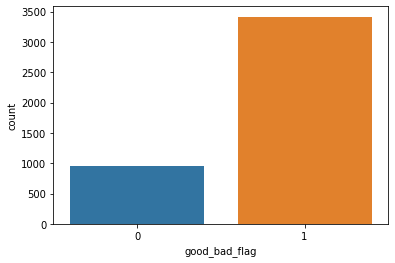

In [47]:
#Distrubute of target variable
sns.countplot(train_df['good_bad_flag'])
#Imbalance Data ->  only 22% raised flag

In [48]:
#Termdays
a=train_df[['termdays', 'good_bad_flag','customerid']].groupby(['termdays'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
a.columns=['termdays','good_bad_flag','sample_size']
a.sort_values(by='good_bad_flag',ascending=False)
#90 termdays is showing best; 15 termdays is the lowest

,termdays,good_bad_flag,sample_size
3,90,0.812500,32
1,30,0.784915,3129
2,60,0.774306,288
0,15,0.773667,919


In [49]:
#bank_account_type
b=train_df[['bank_account_type', 'good_bad_flag','customerid']].groupby(['bank_account_type'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
b.columns=['bank_account_type','good_bad_flag','sample_size']
b.sort_values(by='good_bad_flag',ascending=False)
#Saving account has the higheat chance of default

,bank_account_type,good_bad_flag,sample_size
0,Current,0.890625,64
1,Other,0.852311,887
2,Savings,0.761779,3417


In [50]:
#employment_status_clients
d=train_df[['employment_status_clients', 'good_bad_flag','customerid']].groupby(['employment_status_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
d.columns=['employment_status_clients','good_bad_flag','sample_size']
d.sort_values(by='good_bad_flag',ascending=False)
#Group Contract, Unemployed, Retired and Student as Other

,employment_status_clients,good_bad_flag,sample_size
0,Contract,1.000000,2
5,Unemployed,0.822581,62
3,Self-Employed,0.817935,368
1,Permanent,0.795847,3130
2,Retired,0.714286,7
4,Student,0.711268,142


In [51]:
#other=['Contract','Retired','Unemployed']
#train_df['employment_status_clients']=train_df['employment_status_clients'].apply(lambda x: 'Other' if x in other else x)
#test_df['employment_status_clients']=test_df['employment_status_clients'].apply(lambda x: 'Other' if x in other else x)

#fill NA with Mode
train_df['employment_status_clients'].fillna('Permanent',inplace=True)
test_df['employment_status_clients'].fillna('Permanent',inplace=True)

In [52]:
#new employment_status_clients
d=train_df[['employment_status_clients', 'good_bad_flag','customerid']].groupby(['employment_status_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
d.columns=['employment_status_clients','good_bad_flag','sample_size']
d.sort_values(by='good_bad_flag',ascending=False)

,employment_status_clients,good_bad_flag,sample_size
0,Contract,1.000000,2
5,Unemployed,0.822581,62
3,Self-Employed,0.817935,368
1,Permanent,0.780565,3787
2,Retired,0.714286,7
4,Student,0.711268,142


In [53]:
#bank_name_clients
c=train_df[['bank_name_clients', 'good_bad_flag','customerid']].groupby(['bank_name_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
c.columns=['bank_name_clients','good_bad_flag','sample_size']
c.sort_values(by='good_bad_flag',ascending=False)

,bank_name_clients,good_bad_flag,sample_size
11,Standard Chartered,0.941176,17
16,Wema Bank,0.920000,25
7,Heritage Bank,0.863636,22
1,Diamond Bank,0.859060,298
15,Unity Bank,0.833333,6
10,Stanbic IBTC,0.831169,154
8,Keystone Bank,0.800000,20
17,Zenith Bank,0.796774,310
6,GT Bank,0.783042,1604
14,Union Bank,0.782609,23


In [54]:
other=['Unity Bank','Standard Chartered','Keystone Bank','Heritage Bank','Union Bank','Wema Bank','Sterling Bank']
train_df['bank_name_clients']=train_df['bank_name_clients'].apply(lambda x: 'Other' if x in other else x)
test_df['bank_name_clients']=test_df['bank_name_clients'].apply(lambda x: 'Other' if x in other else x)

In [55]:
#new bank_name_clients
c=train_df[['bank_name_clients', 'good_bad_flag','customerid']].groupby(['bank_name_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
c.columns=['bank_name_clients','good_bad_flag','sample_size']
c.sort_values(by='good_bad_flag',ascending=False)

,bank_name_clients,good_bad_flag,sample_size
1,Diamond Bank,0.859060,298
9,Stanbic IBTC,0.831169,154
11,Zenith Bank,0.796774,310
7,Other,0.787879,165
6,GT Bank,0.783042,1604
10,UBA,0.781341,343
5,First Bank,0.768696,575
0,Access Bank,0.764569,429
3,FCMB,0.754237,118
2,EcoBank,0.740506,158


In [56]:
#Drop 'bank_name_clients'
train_df.drop(['bank_name_clients'],axis=1,inplace=True)
test_df.drop(['bank_name_clients'],axis=1,inplace=True)

In [57]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customerid                           4368 non-null   object 
 1   loanamount                           4368 non-null   float64
 2   totaldue                             4368 non-null   float64
 3   termdays                             4368 non-null   int64  
 4   good_bad_flag                        4368 non-null   int64  
 5   interest                             4368 non-null   float64
 6   bank_account_type                    4368 non-null   object 
 7   longitude_gps                        4368 non-null   float64
 8   latitude_gps                         4368 non-null   float64
 9   employment_status_clients            4368 non-null   object 
 10  Age                                  4368 non-null   int32  
 11  prev_totaldue_mean            

In [58]:
#Todolist in pipieline for transmation & imputation
#Numeric variables: fill missingvalue with mean
#Category: targeting encoding

#Before fit into model, remove customerid and store customerid of test
train_df.drop('customerid',axis=1,inplace=True)
submit_customerid = test_df['customerid']
submit_df=test_df.drop('customerid',axis=1)

In [59]:
train_df.head()

,loanamount,totaldue,termdays,good_bad_flag,interest,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,Age,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,30000.0,34500.0,30,1,4500.0,Other,3.432010,6.433055,Permanent,50,...,11.0,30.0,1.637273,-0.909091,0.000000,8.0,7.0,30.000000,30.000000,31.818182
1,15000.0,17250.0,30,1,2250.0,Savings,3.885298,7.320700,Permanent,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000.0,22250.0,15,1,2250.0,Other,11.139350,10.292041,Permanent,38,...,6.0,17.5,1.000000,0.833333,1.333333,5.0,5.0,18.000000,18.000000,26.666667
3,10000.0,11500.0,15,1,1500.0,Savings,3.985770,7.491708,Permanent,45,...,2.0,22.5,1.000000,7.500000,9.000000,0.0,0.0,25.274832,25.529267,32.000000
4,40000.0,44000.0,30,1,4000.0,Other,7.457913,9.076574,Permanent,36,...,8.0,37.5,1.001250,-3.125000,-10.125000,8.0,8.0,37.500000,37.500000,39.000000


# Fitting Model - CrossValidation

In [60]:
from sklearn.model_selection import train_test_split

x = train_df.drop(['good_bad_flag'], axis=1)
y = train_df['good_bad_flag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

In [61]:
x.columns[x.dtypes != 'object']

Index(['loanamount', 'totaldue', 'termdays', 'interest', 'longitude_gps',
       'latitude_gps', 'Age', 'prev_totaldue_mean', 'prev_loanamount_mean',
       'prev_loanamount_sum', 'prev_interest_mean', 'prev_loan_number',
       'prev_termdays_mean', 'prev_approveDuration_mean',
       'prev_Pay1st_Duration_mean', 'prev_Pay_Duration_mean',
       'prev_1stpayment_ontime', 'prev_ontime',
       'termdays_Pay_OnTime_1stPayment_mean', 'termdays_Pay_OnTime_mean',
       'prev_avg_loan_duration'],
      dtype='object')

In [62]:
x.columns[x.dtypes == 'object']

Index(['bank_account_type', 'employment_status_clients'], dtype='object')

# Logistic Regression

In [63]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

log = LogisticRegression(class_weight='balanced',random_state=23,solver='saga')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features),
            #('log1p', FunctionTransformer(np.log1p, validate=False), numeric_features.tolist())
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('log', log)])

log_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(log_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(log_cv_scores), np.std(log_cv_scores)))

C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: Converge

[0.60285714 0.62571429 0.62285714 0.62285714 0.63037249 0.68481375
 0.66189112 0.64756447 0.63323782 0.63323782]
Estimated Score: 0.637 +/- 0.02


C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


# KNN

In [64]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

knn = KNeighborsClassifier()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features),
            #('log1p', FunctionTransformer(np.log1p, validate=False), numeric_features.tolist())
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('knn', knn)])

knn_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(knn_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(knn_cv_scores), np.std(knn_cv_scores)))

[0.77142857 0.75714286 0.75714286 0.74571429 0.79369628 0.75644699
 0.81088825 0.76790831 0.75644699 0.73638968]
Estimated Score: 0.765 +/- 0.02


# SVM - linear

In [65]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

svm = SVC(kernel="rbf",random_state=23)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features),
            #('log1p', FunctionTransformer(np.log1p, validate=False), numeric_features.tolist())
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('svm', svm)])

svm_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(svm_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(svm_cv_scores), np.std(svm_cv_scores)))

[0.78285714 0.78571429 0.78857143 0.77714286 0.80229226 0.79942693
 0.80802292 0.7765043  0.7965616  0.78223496]
Estimated Score: 0.790 +/- 0.01


# Decision Tree

In [66]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

dt = DecisionTreeClassifier(random_state=23, criterion="entropy")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('dt', dt)])

dt_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(dt_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(dt_cv_scores), np.std(dt_cv_scores)))

[0.67142857 0.66571429 0.64571429 0.7        0.74212034 0.70200573
 0.6991404  0.69054441 0.72492837 0.68194842]
Estimated Score: 0.692 +/- 0.03


# Random Forests

In [67]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

rf = RandomForestClassifier(random_state=23, n_estimators=2000, n_jobs=-1)
#rf = RandomForestClassifier(random_state=23, n_estimators=2000, n_jobs=-1)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('rf', rf)])

rf_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(rf_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(rf_cv_scores), np.std(rf_cv_scores)))

[0.79714286 0.77142857 0.78571429 0.77142857 0.78796562 0.7965616
 0.80802292 0.78796562 0.78223496 0.77936963]
Estimated Score: 0.787 +/- 0.01


# Adaboost

In [68]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

#ab = AdaBoostClassifier(
#    base_estimator=DecisionTreeClassifier(criterion="entropy",class_weight='balanced'), 
#    n_estimators=2000, random_state=23)

ab = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy"), 
    n_estimators=2000, random_state=23)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('ab', ab)])

ab_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(ab_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(ab_cv_scores), np.std(ab_cv_scores)))

[0.66285714 0.67142857 0.65142857 0.73142857 0.7277937  0.70773639
 0.71060172 0.71060172 0.71633238 0.69054441]
Estimated Score: 0.698 +/- 0.03


# XGBoost

In [69]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

xg = XGBClassifier(n_estimators=2000, random_state=23)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('xg', xg)])

xg_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(xg_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(xg_cv_scores), np.std(xg_cv_scores)))

[22:40:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.76285714 0.72571429 0.74857143 0.76       0.77077364 0.76790831
 0.78223496 0.78796562 0.75358166 0.75931232]
Estimated Score: 0.762 +/- 0.02


# LightBoost

In [71]:
#pip install lightgbm

numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

LGB = LGBMClassifier(n_estimators=2000, seed=44, boosting_type="rf", lambda_l2=1,lambda_l1=1,bagging_fraction= 0.5, 
                     bagging_freq= 3,verbose=-1)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('LGB', LGB)])

LGB_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(LGB_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(LGB_cv_scores), np.std(LGB_cv_scores)))

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, sub

In [72]:
pd.DataFrame([[np.mean(log_cv_scores),np.std(log_cv_scores)],
              [np.mean(knn_cv_scores),np.std(knn_cv_scores)],
              [np.mean(svm_cv_scores), np.std(svm_cv_scores)],
              [np.mean(dt_cv_scores), np.std(dt_cv_scores)],
              [np.mean(rf_cv_scores), np.std(rf_cv_scores)],
              [np.mean(ab_cv_scores), np.std(ab_cv_scores)],
              [np.mean(xg_cv_scores), np.std(xg_cv_scores)],
              [np.mean(CatB_cv_scores), np.std(CatB_cv_scores)],
              [np.mean(LGB_cv_scores), np.std(LGB_cv_scores)]],
             columns=['Mean','Std'],
             index=['Logistic','KNN','SVM','DecisionTree','RandomForest','AdaBoost','XGBoost','CatBoost','LGBM'])
#Final Model: RandomForest, LGBM & CatBoost

,Mean,Std
Logistic,0.636540,0.021865
KNN,0.765321,0.021067
SVM,0.789933,0.010426
DecisionTree,0.692354,0.026777
RandomForest,0.786783,0.010978
AdaBoost,0.698075,0.026304
XGBoost,0.761892,0.016659
CatBoost,0.796226,0.011993
LGBM,0.795084,0.011417


# Hyperparameter Tuning

In [73]:
# Helper function to print out the results of hyperparmater tuning in a nice table.

def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    #results['mean_fit_time'] = cv_results['mean_fit_time']
    #results['mean_score_time'] = cv_results['mean_score_time']
    #results['mean_train_score'] = cv_results['mean_train_score']
    #results['std_train_score'] = cv_results['std_train_score']
    results['mean_val_score'] = cv_results['mean_test_score']
    #results['std_val_score'] = cv_results['std_test_score']
    results['rank_val_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_val_score'], ascending=False)
    return results

# LGBM

In [105]:
def objective_LGB(trial):
    numeric_features = x.columns[x.dtypes != 'object']

    categorical_features = x.columns[x.dtypes == 'object']

    #drop_features=[]

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ])

    categorical_transformer = Pipeline(steps=[
          ('encoder', OneHotEncoder(handle_unknown='ignore')),
          ])

    preprocessor = Pipeline(steps=[
          ('ct', ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                #('drop', 'drop', drop_features)
            ],
                remainder = 'drop', 
                sparse_threshold=0)),
            ])
    
    param = {
          'boosting_type': 'rf', #random forest
          'n_jobs': -1,
          'learning_rate': trial.suggest_float('learning_rate',0.0001,0.2901,step=0.01),  
          'num_leaves': trial.suggest_int('num_leaves',2,247,step=5),
          'max_depth':trial.suggest_int('max_depth',4,16),
          'min_samples_leaf':trial.suggest_int('min_samples_leaf',2,247,step=5),
          'max_bin':trial.suggest_int('max_bin',40,790,step=50),
          'lambda_l1': trial.suggest_float('lambda_l1',0.01,10.0,log=True), 
          'lambda_l2': trial.suggest_float('lambda_l2',0.01,10.0,log=True),
          'is_unbalance': False,
          'feature_fraction': trial.suggest_float('feature_fraction',0.1,1),
          'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode',0.1,1),
          'bagging_fraction': trial.suggest_float('bagging_fraction',0.1,1),
          'bagging_freq': trial.suggest_int('bagging_freq',1,10),
          'seed': 23,
          'verbose': -1
           }
    
    LGB = LGBMClassifier(**param)
    
    pipe2 = Pipeline(steps=[('preprocessor', preprocessor),  ('clf', LGB)])
    return cross_val_score(pipe2, x_train, y_train,  cv=5, scoring="accuracy").mean()

In [ ]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)

LGB_study = optuna.create_study(direction='maximize')
LGB_study.optimize(objective_LGB, n_trials=10000)

In [107]:
LGB_study.best_trial

FrozenTrial(number=2999, values=[0.8016593496234901], datetime_start=datetime.datetime(2022, 11, 24, 23, 14, 45, 809658), datetime_complete=datetime.datetime(2022, 11, 24, 23, 14, 46, 387647), params={'learning_rate': 0.2301, 'num_leaves': 72, 'max_depth': 9, 'min_samples_leaf': 37, 'max_bin': 640, 'lambda_l1': 0.028205721291284354, 'lambda_l2': 1.6449530776428907, 'feature_fraction': 0.9063980812586374, 'feature_fraction_bynode': 0.9485849429671525, 'bagging_fraction': 0.664000769178203, 'bagging_freq': 7}, distributions={'learning_rate': FloatDistribution(high=0.2901, log=False, low=0.0001, step=0.01), 'num_leaves': IntDistribution(high=247, log=False, low=2, step=5), 'max_depth': IntDistribution(high=16, log=False, low=4, step=1), 'min_samples_leaf': IntDistribution(high=247, log=False, low=2, step=5), 'max_bin': IntDistribution(high=790, log=False, low=40, step=50), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=0.01, step=None), 'lambda_l2': FloatDistribution(high=10.0, l

In [108]:
print('Best trial: score {}, params {}'.format(LGB_study.best_trial.value, LGB_study.best_trial.params))

Best trial: score 0.8016593496234901, params {'learning_rate': 0.2301, 'num_leaves': 72, 'max_depth': 9, 'min_samples_leaf': 37, 'max_bin': 640, 'lambda_l1': 0.028205721291284354, 'lambda_l2': 1.6449530776428907, 'feature_fraction': 0.9063980812586374, 'feature_fraction_bynode': 0.9485849429671525, 'bagging_fraction': 0.664000769178203, 'bagging_freq': 7}


In [109]:
fig = optuna.visualization.plot_optimization_history(LGB_study)
fig.show()

In [111]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features=[]

numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ])

categorical_transformer = Pipeline(steps=[
          ('encoder', OneHotEncoder(handle_unknown='ignore')),
          ])

preprocessor = Pipeline(steps=[
          ('ct', ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                #('drop', 'drop', drop_features)
            ],
                remainder = 'drop', 
                sparse_threshold=0)),
            ])
    
clf2 = LGBMClassifier(**LGB_study.best_params)
    
pipe2 = Pipeline(steps=[('preprocessor', preprocessor),  ('clf', clf2)])
pipe2 = pipe2.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=37. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.9063980812586374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063980812586374
[LightGBM] [Warning] lambda_l1 is set=0.028205721291284354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028205721291284354
[LightGBM] [Warning] bagging_fraction is set=0.664000769178203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.664000769178203
[LightGBM] [Warning] lambda_l2 is set=1.6449530776428907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6449530776428907
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [112]:
preds = pipe2.predict(x_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.43      0.22      0.29       184
           1       0.82      0.92      0.87       690

    accuracy                           0.77       874
   macro avg       0.62      0.57      0.58       874
weighted avg       0.74      0.77      0.75       874



Text(0.5, 257.44, 'Predicted label')

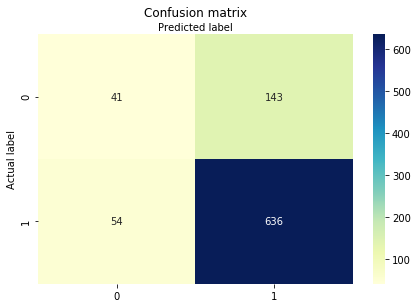

In [113]:
#Confusion Matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Final Submit

In [114]:
final_pred = pipe2.predict(submit_df)

In [115]:
submission = pd.DataFrame({
        "customerid": submit_customerid,
        "Survived": final_pred
    })

In [116]:
submission.to_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/submission.csv', index=False)